# Exercise 3

## Individual household electric power consumption

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import math

sys.path.insert(0, "./..")

from utils import dbscan, pca, silhouette_score, kmeans, kmeans_objective


In [2]:
df = pd.read_csv("./household_power_consumption.txt", sep=';')

/tmp/ipykernel_3554/4283626975.py:1: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("./household_power_consumption.txt", sep=';')


In [3]:
df.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [4]:
df.shape

(2075259, 9)

Attributes information:

- **date**: Date in format dd/mm/yyyy
- **time**: time in format hh:mm:ss
- **global_active_power**: household global minute-averaged active power (in kilowatt)
- **global_reactive_power**: household global minute-averaged reactive power (in kilowatt)
- **voltage**: minute-averaged voltage (in volt)
- **global_intensity**: household global minute-averaged current intensity (in ampere)
- **sub_metering_1**: energy sub-metering No. 1 (in watt-hour of active energy). It corresponds to the kitchen, containing mainly a dishwasher, an oven and a microwave (hot plates are not electric but gas powered).
- **sub_metering_2**: energy sub-metering No. 2 (in watt-hour of active energy). It corresponds to the laundry room, containing a washing-machine, a tumble-drier, a refrigerator and a light.
- **sub_metering_3**: energy sub-metering No. 3 (in watt-hour of active energy). It corresponds to an electric water-heater and an air-conditioner.

In [5]:
numerical_colums = ["Global_active_power", "Global_reactive_power", "Voltage", 
                    "Global_intensity", "Sub_metering_1", "Sub_metering_2","Sub_metering_3"]

### Data pre-treatment
*You can use as data points each time measure or the average value per day. Propose a coherent way for dealing with missing values and, if needed, a way for decimating the data.*

Let's check which colums contains missing values. We should also check missing values for the combination of Date and Time too, since we might be missing either the Time or the Date for a certain time instant. All inconsistent values must be substituted with "NaN".

In [6]:
df["DateTime"] = pd.to_datetime(df["Date"] + df["Time"], format="%d/%m/%Y%H:%M:%S")
df["Date"] = pd.to_datetime(df["Date"], format="%d/%m/%Y")
df["Time"] = pd.to_datetime(df["Time"], format="%H:%M:%S")

df[numerical_colums] = df[numerical_colums].apply(pd.to_numeric, errors="coerce") #coerce arg sets non-numeric values to NaN

In [7]:
df.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,DateTime
0,2006-12-16,1900-01-01 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0,2006-12-16 17:24:00
1,2006-12-16,1900-01-01 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0,2006-12-16 17:25:00
2,2006-12-16,1900-01-01 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0,2006-12-16 17:26:00
3,2006-12-16,1900-01-01 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0,2006-12-16 17:27:00
4,2006-12-16,1900-01-01 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0,2006-12-16 17:28:00


We can now count the number of missing value for each column

In [8]:
df.isna().sum()

Date                         0
Time                         0
Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
DateTime                     0
dtype: int64

We can fill missing values by using the median of the other values corresponding to that specific minute, hour, day and month. Without taking into account that specific information, we would loose information about seasonality. 

In [9]:
df["TimeInTheYear"] = df["DateTime"].dt.strftime("%m-%d %H:%M")

median_over_years = df.groupby("TimeInTheYear")[numerical_colums].transform("median")

for column in numerical_colums:
       df[column].fillna(median_over_years[column], inplace=True)

Let's check if everything's fine

In [10]:
df.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,DateTime,TimeInTheYear
0,2006-12-16,1900-01-01 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0,2006-12-16 17:24:00,12-16 17:24
1,2006-12-16,1900-01-01 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0,2006-12-16 17:25:00,12-16 17:25
2,2006-12-16,1900-01-01 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0,2006-12-16 17:26:00,12-16 17:26
3,2006-12-16,1900-01-01 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0,2006-12-16 17:27:00,12-16 17:27
4,2006-12-16,1900-01-01 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0,2006-12-16 17:28:00,12-16 17:28


In [11]:
df.isna().sum()

Date                     0
Time                     0
Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
DateTime                 0
TimeInTheYear            0
dtype: int64

(**Global_active_power***1000/60 - **Sub_metering_1** - **Sub_metering_2** - **Sub_metering_3**) represents the active energy consumed every minute (in watt hour) in the household by electrical equipment not measured in sub-meterings 1, 2 and 3.
We convert  **Global_active_power** and **Global_reactive_power** to watt/hour to bring these columns to the same unit.

In [12]:
df["Global_active_power"] = df["Global_active_power"].apply(lambda x : x*1000/60)
df["Global_reactive_power"] = df["Global_reactive_power"].apply(lambda x : x*1000/60)

We can now discard the colums that where used for previous chacks and take the average per day.

In [13]:
df = df.drop(["DateTime","TimeInTheYear", "Time"], axis=1)
df = df.groupby("Date").mean().reset_index()
df.head()

,Date,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,2006-12-16,50.891246,1.469781,236.243763,13.082828,0.000000,1.378788,12.439394
1,2006-12-17,39.241435,2.615810,240.087028,9.999028,1.411806,2.907639,9.264583
2,2006-12-18,25.507245,1.872593,241.231694,6.421667,0.738194,1.820139,9.734722
3,2006-12-19,19.284653,1.747014,241.999313,4.926389,0.582639,5.279167,4.303472
4,2006-12-20,25.760972,1.863403,242.308062,6.467361,0.000000,1.838889,9.765972


Finally we drop the Date column since it is the last non-numerical value and we normalize values.

In [14]:
df_num = df.drop(["Date"], axis=1)
df_num = df_num.subtract(df_num.mean(numeric_only=True))
df_num = df_num.divide(df_num.std())
df_num.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,4.679636,-1.047787,-2.273124,4.870183,-1.006412,0.064246,2.340515
1,3.014686,0.984054,-0.371951,3.096251,0.275164,1.119678,1.101120
2,1.051844,-0.333626,0.194288,1.038402,-0.336311,0.368930,1.284655
3,0.162532,-0.556270,0.574011,0.178255,-0.477518,2.756847,-0.835616
4,1.088105,-0.349919,0.726742,1.064688,-1.006412,0.381874,1.296854


/tmp/ipykernel_3554/2615952104.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


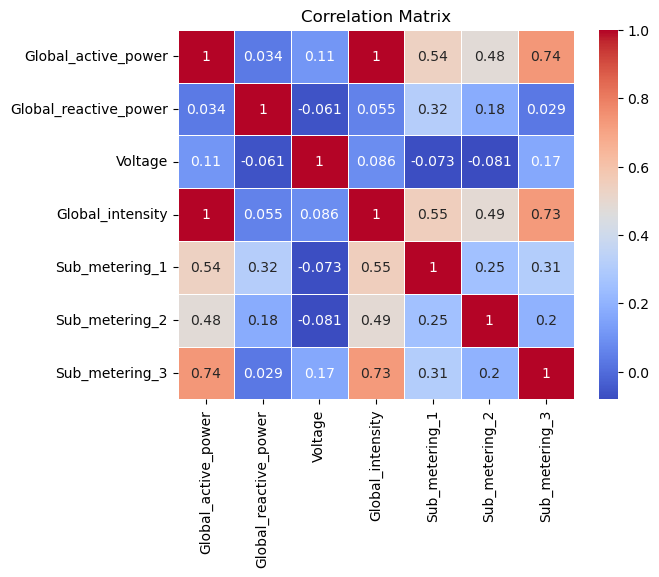

In [15]:
correlation_matrix = df.corr()

plt.figure()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

There is strong correlation between the Global_active_power and the Global_intensity. We drop the second one

In [16]:
df_num = df_num.drop(["Global_intensity"], axis=1)

### Clustering

*Perform a cluster analysis with k-means or with a density-based clustering.*

It was chosen to use the DBSCAN algorithm, since doesn't require the number of clusters to be specified a-priori

In [17]:
X = df_num.to_numpy(dtype=np.float32)
clusters = dbscan(X, eps=1, min_pts=5)

In [18]:
np.unique(clusters)

array([-1,  1,  2])

*Perform a dimensional reduction with a method of your choice, retaining only two coordinates, and visualize the clusters in the space of these coordinates*

We use standard PCA

In [19]:
X_transformed, _ = pca(X, n_components=2)

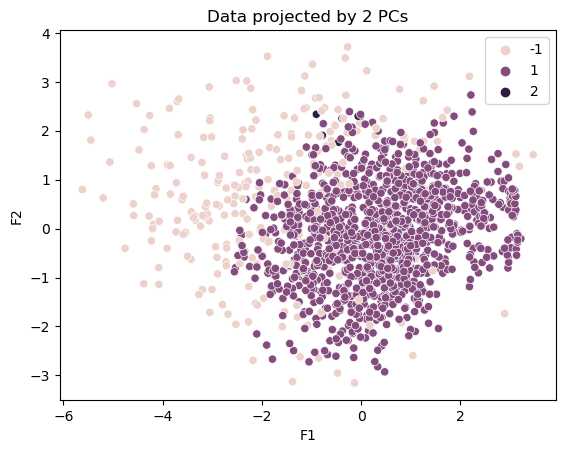

In [20]:
plt.figure()
sns.scatterplot(x = X_transformed[:,0], y = X_transformed[:,1], hue=clusters)
plt.xlabel('F1')
plt.ylabel('F2')
plt.legend(loc='upper right')
plt.title('Data projected by 2 PCs')
plt.show()

*Now recompute the clusters, but with the goal of performing Markov State Modeling (hint: the number of clusters necessary to perform MSM is typically larger).*

We now tune the parameters of DBSCAN *eps* and *min_pts* to obtain a higher number of clusters.

In [21]:
eps_array = np.arange(0.1, 1.1, 0.1)
min_pts_array = np.arange(2, 10)

best_params = (eps_array[0], min_pts_array[0])
best_score = -np.inf

for eps in eps_array:
    for min_pts in min_pts_array:
        labels = dbscan(X, eps=eps, min_pts=min_pts)
        score = silhouette_score(X, labels)
        if math.isnan(score):
            break #it will be nan also for bigger min_pts values
        print(f"Eps = {eps}, Min Pts = {min_pts}, Silhouette Score = {score}, Number of clusters = {len(np.unique(clusters))}")
        if score > best_score:
            best_score=score
            best_params = (eps, min_pts)
        

print(f"\nBest parameters: (Eps = {best_params[0]}, Min Pts = {best_params[1]}), with Silhouette Score = {best_score}")

Eps = 0.1, Min Pts = 2, Silhouette Score = -0.27701295391394, Number of clusters = 3
Eps = 0.1, Min Pts = 3, Silhouette Score = 0.10317754283570087, Number of clusters = 3
Eps = 0.1, Min Pts = 4, Silhouette Score = 0.10317754283570087, Number of clusters = 3


/home/lollo/Repos/unsupervised-learning/exercise3/./../utils.py:243: RuntimeWarning: invalid value encountered in double_scalars
  silhouette_coefficients[i] = (b_i - a_i) / max(a_i, b_i)


Eps = 0.2, Min Pts = 2, Silhouette Score = -0.4110337066143802, Number of clusters = 3
Eps = 0.2, Min Pts = 3, Silhouette Score = -0.015873119761692953, Number of clusters = 3
Eps = 0.2, Min Pts = 4, Silhouette Score = -0.019424135645999395, Number of clusters = 3
Eps = 0.2, Min Pts = 5, Silhouette Score = -0.02011041192162844, Number of clusters = 3
Eps = 0.2, Min Pts = 6, Silhouette Score = -0.013674026298519017, Number of clusters = 3
Eps = 0.2, Min Pts = 7, Silhouette Score = -0.017465544531481147, Number of clusters = 3
Eps = 0.2, Min Pts = 8, Silhouette Score = 0.10956195911763775, Number of clusters = 3
Eps = 0.30000000000000004, Min Pts = 2, Silhouette Score = -0.3875806211641164, Number of clusters = 3
Eps = 0.30000000000000004, Min Pts = 3, Silhouette Score = -0.3869347426382858, Number of clusters = 3
Eps = 0.30000000000000004, Min Pts = 4, Silhouette Score = -0.34829667736679093, Number of clusters = 3
Eps = 0.30000000000000004, Min Pts = 5, Silhouette Score = -0.2387728413

Unfortunately, the parameters settings with the best score lead to a very low number of clusters, which is unsuitable for MSM. We try now k-means, where it is possible to fix the number of clusters as a parameter.

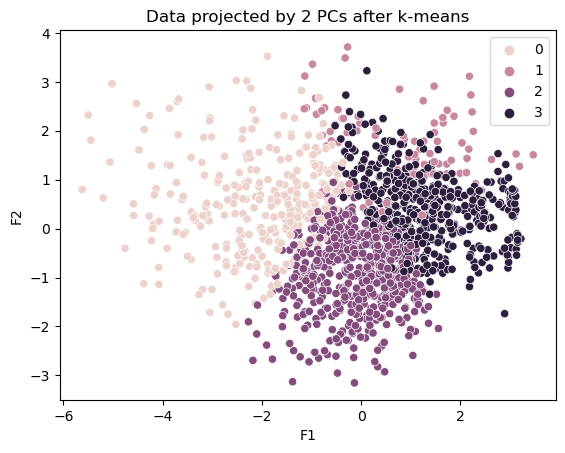

In [43]:
clusters, _ = kmeans(X, 4)

plt.figure()
sns.scatterplot(x = X_transformed[:,0], y = X_transformed[:,1], hue=clusters)
plt.xlabel('F1')
plt.ylabel('F2')
plt.legend(loc='upper right')
plt.title('Data projected by 2 PCs after k-means')
plt.show()

/tmp/ipykernel_3554/2039882122.py:2: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.plot_date(df["Date"][-365:], clusters[-365:], marker='o', linestyle='-')


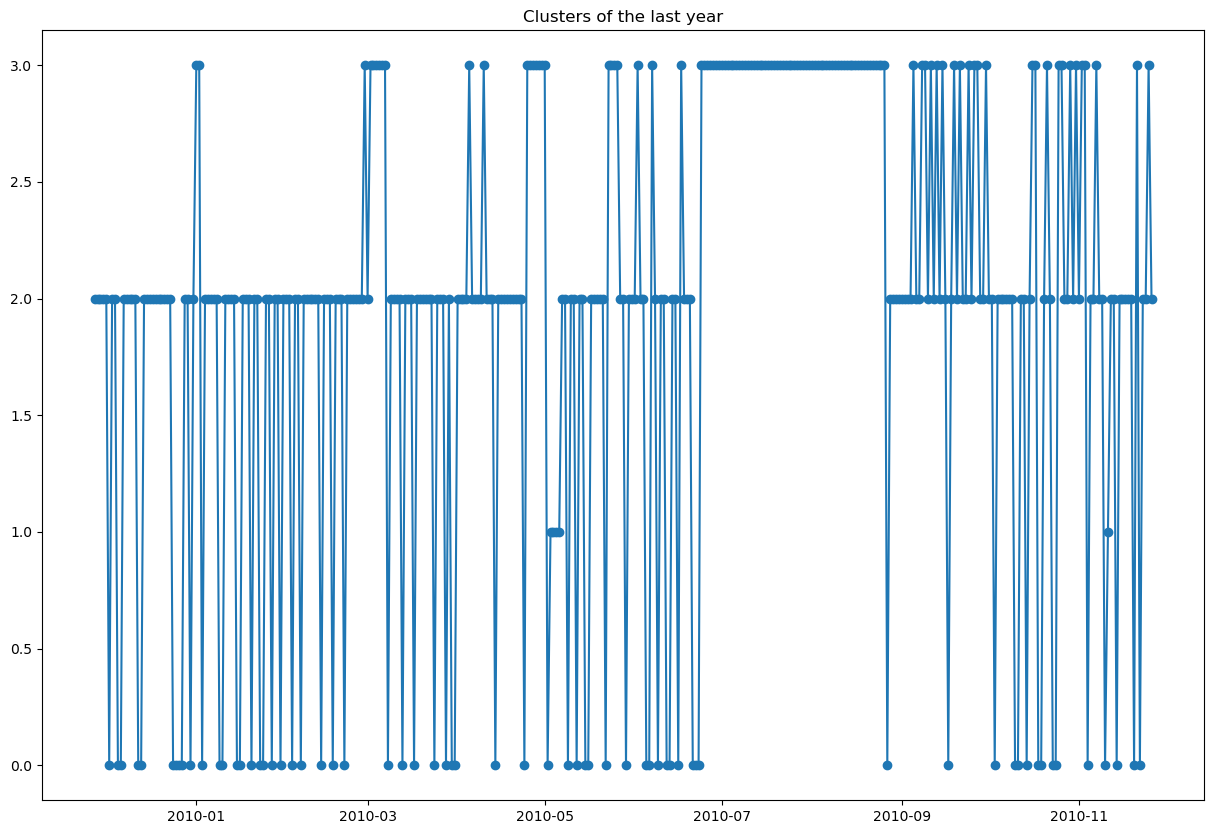

In [44]:
plt.figure(figsize=(15,10))
plt.plot_date(df["Date"][-365:], clusters[-365:], marker='o', linestyle='-')
plt.title("Clusters of the last year")
plt.show()

Now we try to identify a good value for the k parameter, considering that it should be a relatively high number

In [23]:
losses = []
k_array = np.arange(2, 500)

for k in k_array:
    clusters, centroids = kmeans(X, k)
    losses.append(kmeans_objective(X, clusters, centroids))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


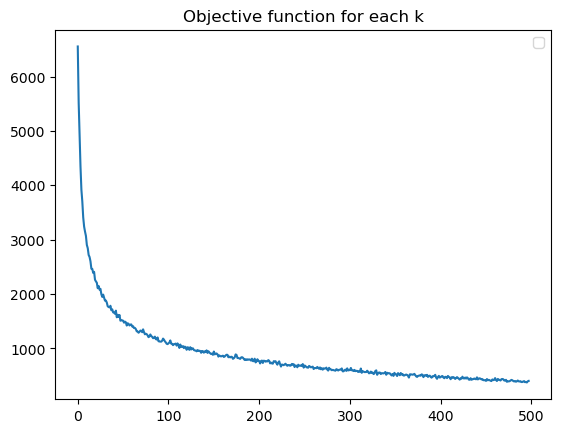

In [24]:
x=np.arange(0,len(losses))
plt.figure()
plt.title('Objective function for each k')
plt.plot(x, losses)
plt.legend()
plt.show()

It is difficult to identify a clear knee-point in the plot above. We consider 200 to be a reasonable value.

In [25]:
clusters, _ = kmeans(X, 100)

*Choose a time lag $τ$ , and estimate the transition probability matrix between each pair of the clusters found in point 4. $π_{α,β} = P(β, τ |α, 0)$*

We arbitrarily choose $τ=1$ (day).

In [26]:
def get_ordered_spectrum(M):
    eigenvalues, right_eigenvectors = np.linalg.eig(M)
    _, left_eigenvectors = np.linalg.eig(M.T)

    sorting_indexes = np.argsort(np.abs(eigenvalues))[::-1]
    eigenvalues = eigenvalues[sorting_indexes]
    left_eigenvectors = left_eigenvectors[:, sorting_indexes]
    right_eigenvectors = right_eigenvectors[:, sorting_indexes]
    
    return eigenvalues, left_eigenvectors, right_eigenvectors

In [27]:
from utils import estimate_transition_prob_matrix

tau = 1
P = estimate_transition_prob_matrix(clusters, tau)

*From the spectrum compute the relaxation times of the system. Choose an appropriate number of Markov states. Find the Markov states by inspecting the sign of the eigenvectors.*

In [28]:
eigenvalues, left_eigenvectors, right_eigenvectors = get_ordered_spectrum(P)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


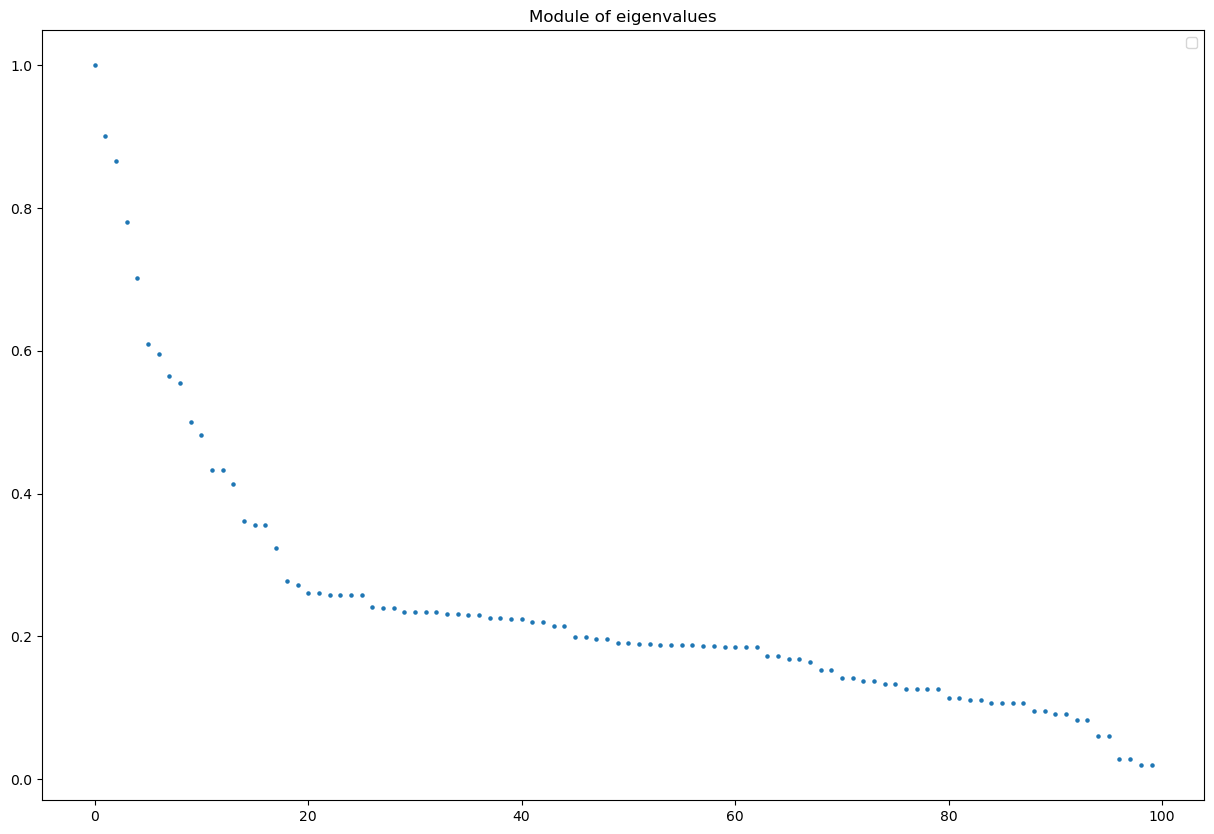

In [29]:
x=np.arange(len(eigenvalues))
plt.figure(figsize=(15,10))
plt.title('Module of eigenvalues')
plt.scatter(x, np.abs(eigenvalues), marker='o', s=5)
plt.legend()
plt.show()

In [30]:
relax_times = -np.divide(tau, np.log(np.abs(eigenvalues[1:])))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


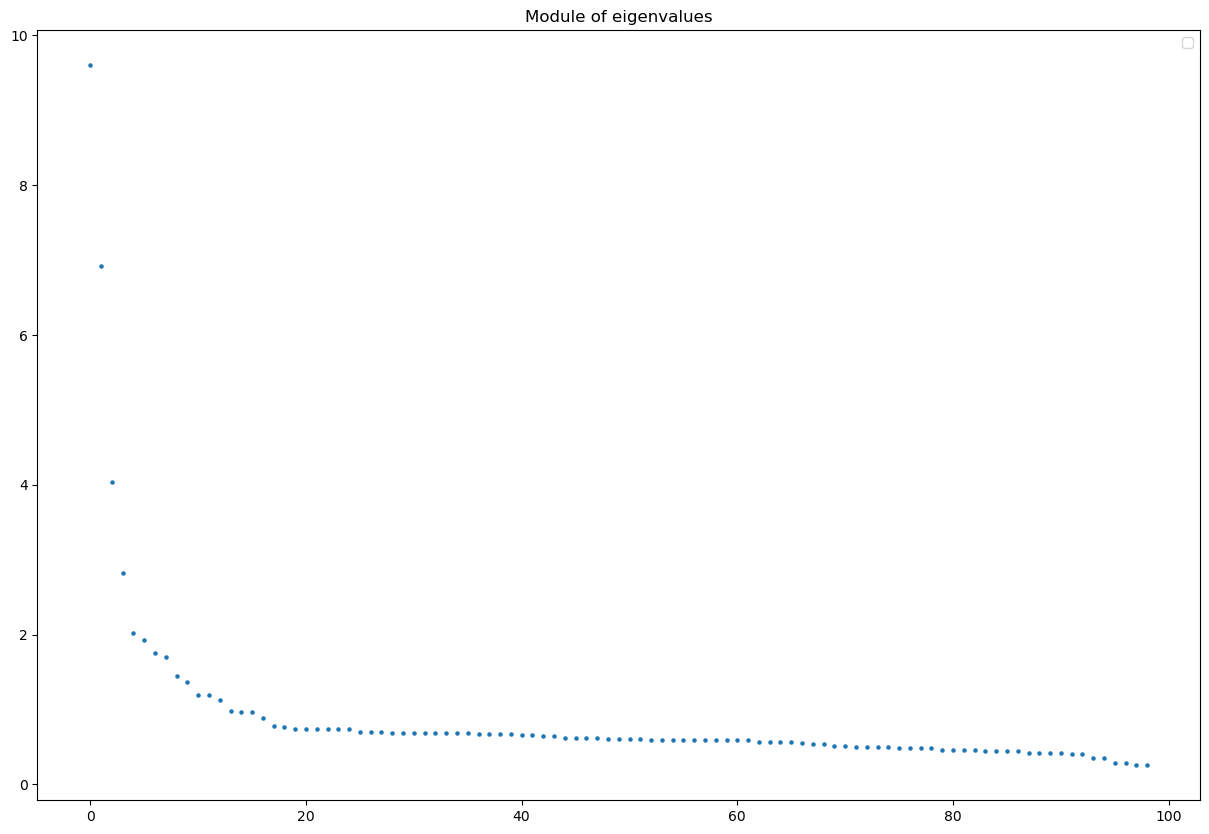

In [31]:
x=np.arange(len(relax_times))
plt.figure(figsize=(15,10))
plt.title('Module of eigenvalues')
plt.scatter(x, relax_times, marker='o', s=5)
plt.legend()
plt.show()

Based on the plot above, we consider 4 relaxation times. This leads us to the formation of $2^{3}=8$ macrostates.

In [32]:
def get_markov_states(left_eigenvectors):
    C1 = np.where(np.logical_and(np.greater(left_eigenvectors[:,1],0),
                                np.logical_and(np.greater(left_eigenvectors[:,2],0),
                                               np.greater(left_eigenvectors[:,3],0))))[0]

    C2 = np.where(np.logical_and(np.less(left_eigenvectors[:,1],0),
                                np.logical_and(np.greater(left_eigenvectors[:,2],0),
                                               np.greater(left_eigenvectors[:,3],0))))[0]

    C3 = np.where(np.logical_and(np.greater(left_eigenvectors[:,1],0),
                                np.logical_and(np.less(left_eigenvectors[:,2],0),
                                               np.greater(left_eigenvectors[:,3],0))))[0]

    C4 = np.where(np.logical_and(np.greater(left_eigenvectors[:,1],0),
                                np.logical_and(np.greater(left_eigenvectors[:,2],0),
                                               np.less(left_eigenvectors[:,3],0))))[0]
    
    C5 = np.where(np.logical_and(np.less(left_eigenvectors[:,1],0),
                                np.logical_and(np.greater(left_eigenvectors[:,2],0),
                                               np.less(left_eigenvectors[:,3],0))))[0]
    
    C6 = np.where(np.logical_and(np.greater(left_eigenvectors[:,1],0),
                                np.logical_and(np.less(left_eigenvectors[:,2],0),
                                               np.less(left_eigenvectors[:,3],0))))[0]
    
    C7 = np.where(np.logical_and(np.less(left_eigenvectors[:,1],0),
                                np.logical_and(np.less(left_eigenvectors[:,2],0),
                                               np.greater(left_eigenvectors[:,3],0))))[0]
    
    C8 = np.where(np.logical_and(np.less(left_eigenvectors[:,1],0),
                                np.logical_and(np.less(left_eigenvectors[:,2],0),
                                               np.less(left_eigenvectors[:,3],0))))[0]
    
    return C1, C2, C3, C4, C5, C6, C7, C8

In [33]:
C1, C2, C3, C4, C5, C6, C7, C8 = get_markov_states(left_eigenvectors)

In [34]:
C5

array([ 1,  2,  3,  5,  7,  8, 12, 17, 23, 25, 27, 29, 31, 32, 36, 37, 38,
       41, 44, 46, 49, 52, 55, 56, 58, 59, 61, 62, 65, 68, 69, 73, 74, 75,
       77, 79, 82, 83, 85, 88, 89, 90, 92, 94, 97, 99])

In [35]:
X.shape[0]

1442

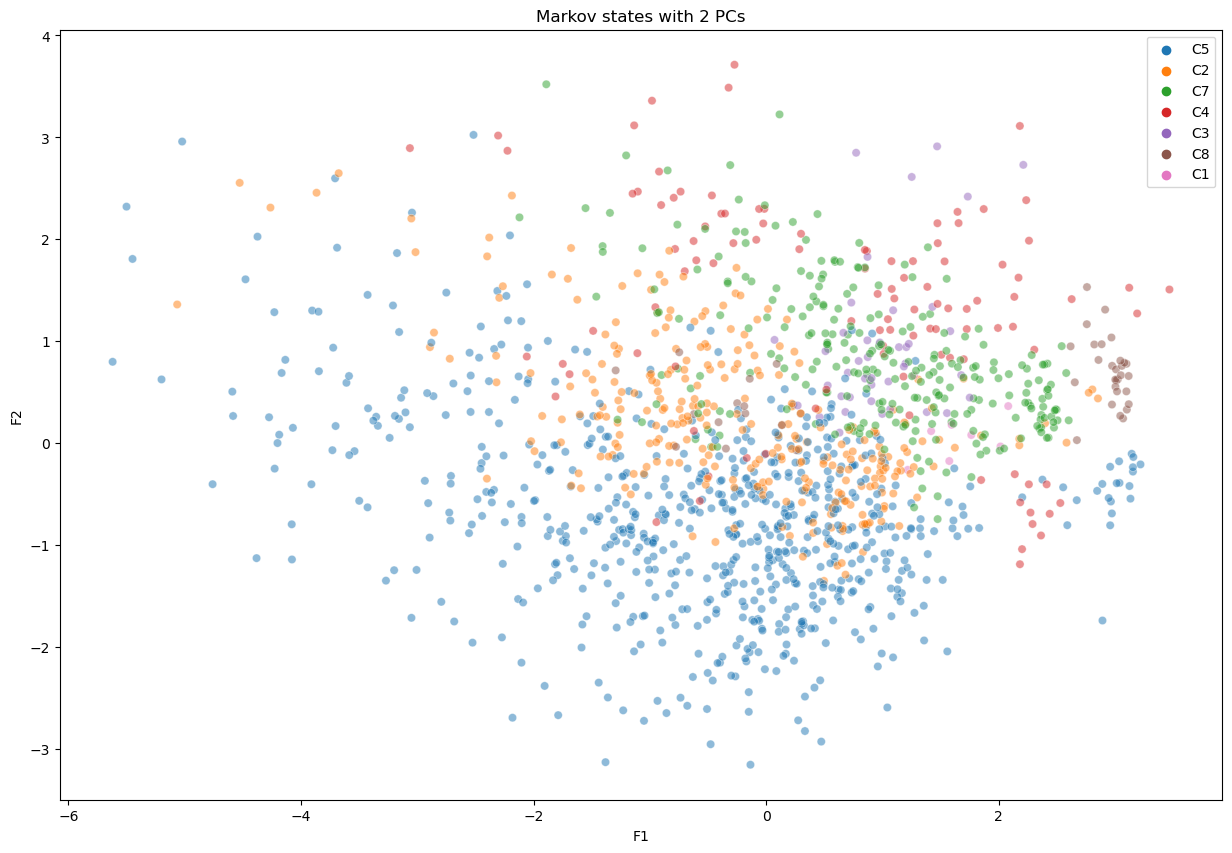

In [36]:
macro_states = np.ones(X.shape[0])
for i in C2:
    macro_states[np.where(clusters==i)[0]] = 2
for i in C3:
    macro_states[np.where(clusters==i)[0]] = 3
for i in C4:
    macro_states[np.where(clusters==i)[0]] = 4
for i in C5:
    macro_states[np.where(clusters==i)[0]] = 5
for i in C6:
    macro_states[np.where(clusters==i)[0]] = 6
for i in C7:
    macro_states[np.where(clusters==i)[0]] = 7
for i in C8:
    macro_states[np.where(clusters==i)[0]] = 8

label_map = {1: 'C1', 2: 'C2', 3: 'C3', 4:'C4', 5: 'C5', 6: 'C6', 7: 'C7', 8:'C8'}

plt.figure(figsize=(15,10))
sns.scatterplot(x=X_transformed[:, 0], y=X_transformed[:, 1], hue=pd.Series(macro_states).map(label_map), alpha=0.5)
plt.xlabel('F1')
plt.ylabel('F2')
plt.legend(loc='upper right')
plt.title('Markov states with 2 PCs')
plt.show()

/tmp/ipykernel_3554/4210207645.py:2: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.plot_date(df["Date"], macro_states, marker='o', linestyle='-')


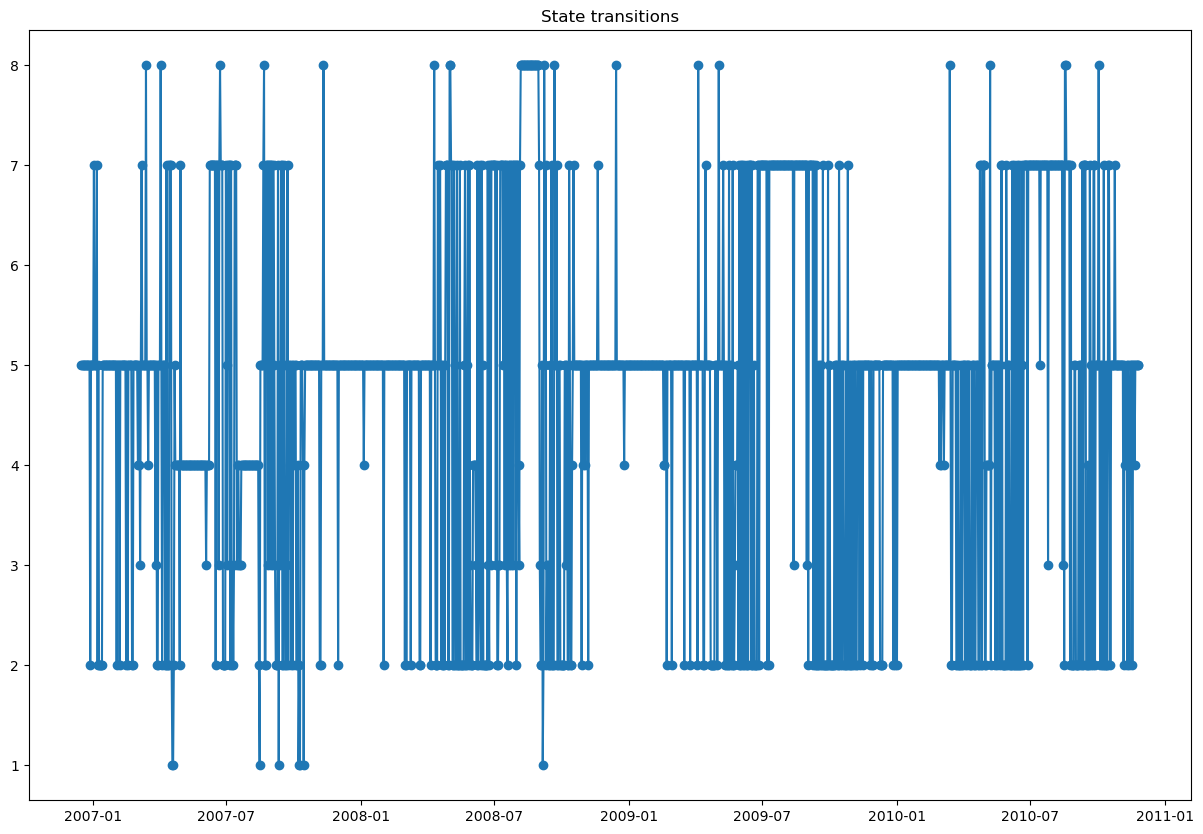

In [41]:
plt.figure(figsize=(15,10))
plt.plot_date(df["Date"], macro_states, marker='o', linestyle='-')
plt.title("State transitions")
plt.show()

/tmp/ipykernel_3554/3940180605.py:2: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.plot_date(df["Date"][-365:], macro_states[-365:], marker='o', linestyle='-')


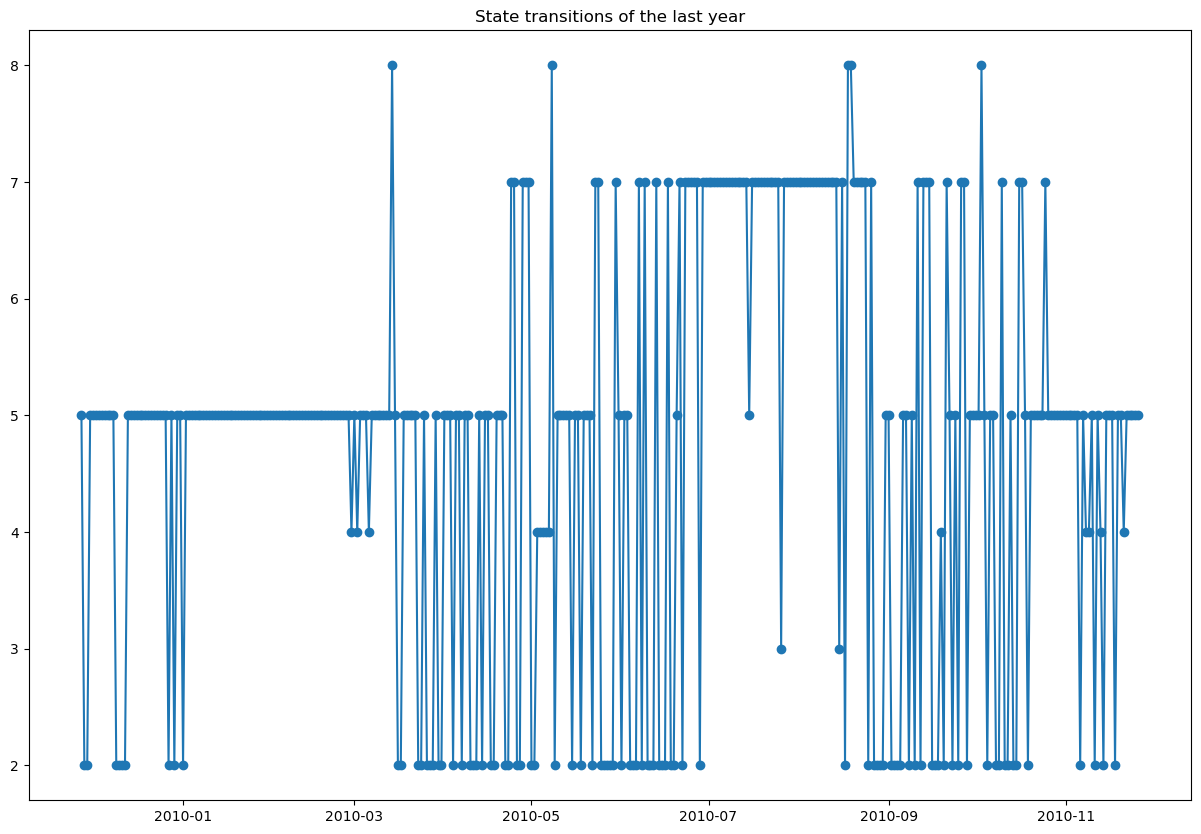

In [42]:
plt.figure(figsize=(15,10))
plt.plot_date(df["Date"][-365:], macro_states[-365:], marker='o', linestyle='-')
plt.title("State transitions of the last year")
plt.show()

*Comment if the MSM clusters have some meaning*

It is difficult to find a specific interpretation for each of the Markov state. However, the plots above provides us with some hints on the possible meaning of some of them. C7 is mainly present in the period going from May 2010 to September 2010. This may mean that it is related to a lower energy consumption, due to the summer season. In a similar way, state 5 is rarely present during the summer and is heavily present during the rest of the year, hence, it may be related to a higher energy consumption. States 8, 3 and 4 are rare, hence they may be related to a anomalous scenarios, such as very high or low level of consumption (e.g. housold owners are not at home). State 2 exclude both the core of the summer and winter period, suggesting that it may correspond to an average level of energy.